# Import libraries

In [26]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import datetime
import os
import numpy as np
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder

In [27]:
warnings.filterwarnings("ignore")

# Data Import

In [28]:
df = pd.read_csv("clean_data.csv")

In [29]:
pd.set_option('display.max_columns', None)

In [30]:
new_column_names = {'Dates Review': 'date_review',
                    'Day Review': 'day_review',
                    'Month Review': 'month_review',
                   'Month Review Number': 'month_review_num',
                   'Year Review': 'year_review',
                   'Verified': 'verified',
                   'Customer Name':'name',
                   'Month Flown': 'month_fly',
                   'Month Flown Number': 'month_fly_num',
                    'Year Flown':'year_fly',
                   'Month Year Flown': 'month_year_fly',
                   'Country': 'country',
                   'Aircraft': 'aircraft',
                   'Type Of Traveller': 'type',
                   'Seat Type': 'seat_type',
                   'Route': 'route',
                   'Seat Comfort': 'seat_comfort',
                   'Cabin Staff Service': 'cabit_serv',
                   'Food & Beverages': 'food',
                   'Ground Service': 'ground_service',
                   'Wifi & Connectivity': 'wifi',
                   'Value For Money': 'money_value',
                   'Recommended': 'recommended',
                   'Review': 'review'}

df.rename(columns=new_column_names, inplace=True)

In [31]:
df = df.drop(columns=['month_fly', 'month_fly_num','year_fly', 'day_review', 'month_review', 'month_review_num', 'year_review'])

In [32]:
df.dtypes

ID                  int64
date_review        object
verified             bool
name               object
month_year_fly     object
country            object
aircraft           object
type               object
seat_type          object
route              object
seat_comfort      float64
cabit_serv        float64
food              float64
ground_service    float64
wifi              float64
money_value         int64
recommended        object
review             object
dtype: object

In [33]:
df['recommended'] = df['recommended'].replace({'yes': 1, 'no': 0})
df['verified'] = df['verified'].astype('str')
df['verified'] = df['verified'].replace({'True': 1, 'False': 0})

In [34]:
df['aircraft'].fillna(0, inplace=True)
df['wifi'].fillna(0, inplace=True)
df['aircraft'] = df['aircraft'].apply(lambda x: 1 if x != 0 else 0)
df['wifi'] = df['wifi'].apply(lambda x: 1 if x != 0 else 0)

In [35]:
#df['date_review'] = df['date_review'].astype('datetime64[ns]')
#df['month_year_fly'] = df['month_year_fly'].astype('datetime64[ns]')
df['seat_comfort'] = pd.to_numeric(df['seat_comfort'], errors='coerce').astype('Int64')
df['cabit_serv'] = pd.to_numeric(df['cabit_serv'], errors='coerce').astype('Int64')
df['food'] = pd.to_numeric(df['food'], errors='coerce').astype('Int64')
df['ground_service'] = pd.to_numeric(df['ground_service'], errors='coerce').astype('Int64')

In [36]:
df.head(3)

,ID,date_review,verified,name,month_year_fly,country,aircraft,type,seat_type,route,seat_comfort,cabit_serv,food,ground_service,wifi,money_value,recommended,review
0,0,2024-03-02,1,T Collins,02-2024,United Kingdom,1,Solo Leisure,Business Class,Heathrow to Oslo,4,5,5,5,0,5,1,I upgraded at check in to Club Europe seat 1D ...
1,1,2024-03-01,1,Armando Castro,06-2023,Australia,0,Solo Leisure,Economy Class,Sydney to Porto via Singapore / London,<NA>,<NA>,<NA>,<NA>,0,1,0,"I bought a return trip with BA, through Webjet..."
2,2,2024-02-29,1,Simon Channon,02-2024,United Kingdom,1,Couple Leisure,Economy Class,London Heathrow to Lisbon,1,3,1,2,0,3,0,Poor from start to finish. Six months after pu...


# Null Handling

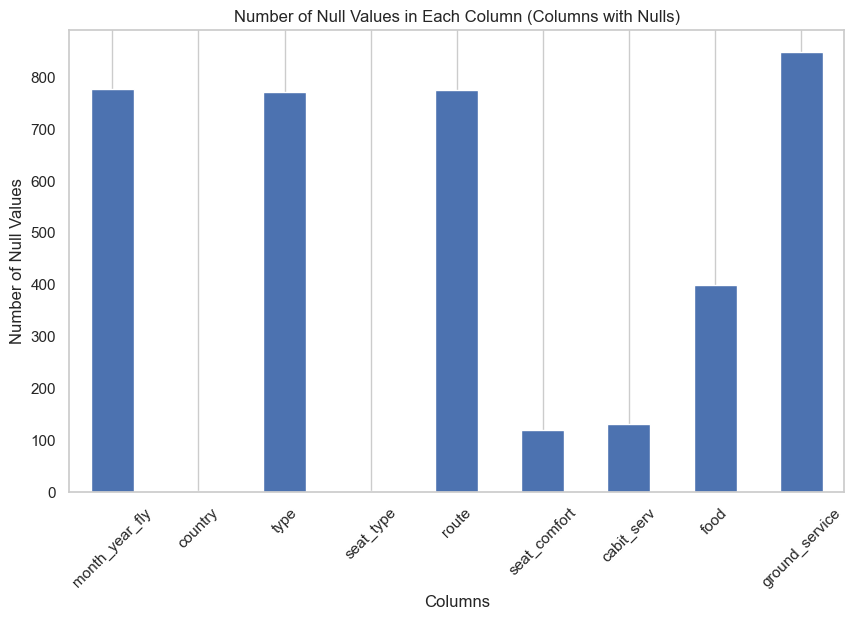

In [37]:
null_counts = df.isnull().sum()

null_counts_filtered = null_counts[null_counts > 0]

null_counts_filtered.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Null Values in Each Column (Columns with Nulls)')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45)  
plt.grid(axis='y')  
plt.show()

In [38]:
df.seat_comfort

0          4
1       <NA>
2          1
3          1
4       <NA>
        ... 
3753       2
3754       4
3755    <NA>
3756       1
3757       4
Name: seat_comfort, Length: 3758, dtype: Int64

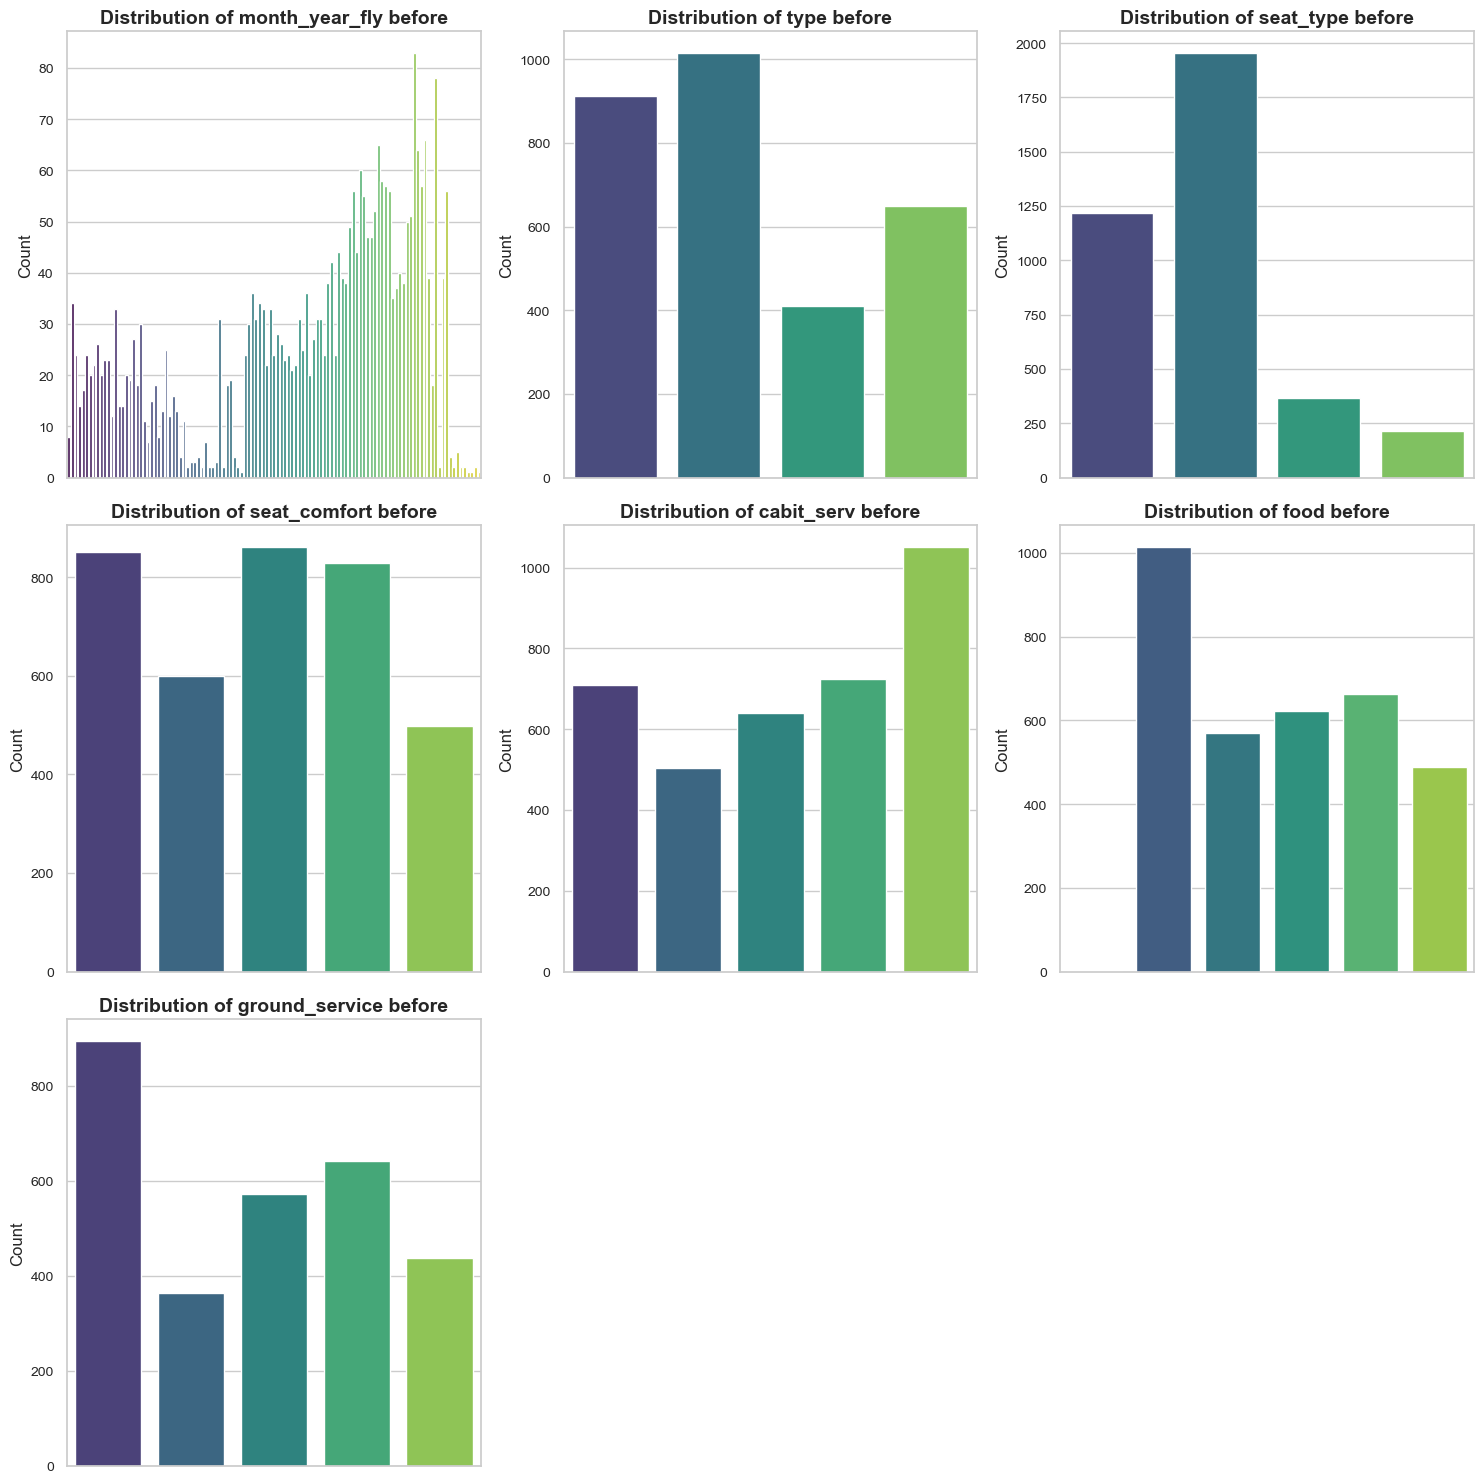

In [39]:
# Assuming df is your DataFrame containing the data

categorical_columns = ['month_year_fly', 'type', 'seat_type', 'seat_comfort',
                        'cabit_serv', 'food', 'ground_service']
num_columns = 3
num_rows = (len(categorical_columns) - 1) // num_columns + 1

plt.figure(figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    
    # Handle NaN values in the current column
    column_values = df[column].dropna()
    
    # Plot count distribution
    sns.countplot(x=column_values, palette="viridis")
    
    plt.title(f'Distribution of {column} before', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

plt.show()

In [40]:
# Handling 'seat_comfort', 'cabit_serv', 'food', 'ground_service'
columns_with_missing = ['seat_comfort', 'cabit_serv', 'food', 'ground_service']
imputer = KNNImputer(n_neighbors=5)
df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

In [41]:
review_columns = ['seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']
df[review_columns] = df[review_columns].round()

In [42]:
# Handling 'country' and 'seat_type' NAs
df['country'].fillna(df['country'].mode()[0], inplace = True)
df['seat_type'].fillna(df['seat_type'].mode()[0], inplace = True)

In [43]:
# Handling 'type' NAs
df_known_type = df[df['type'].notna()]
df_missing_type = df[df['type'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_type[features], df_known_type['type'])

predicted_type = rf_classifier.predict(df_missing_type[features])
df.loc[df['type'].isna(), 'type'] = predicted_type

In [44]:
# Handling 'route' NAs
df_known_route = df[df['route'].notna()]
df_missing_route = df[df['route'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_route[features], df_known_route['route'])

predicted_route = rf_classifier.predict(df_missing_route[features])
df.loc[df['route'].isna(), 'route'] = predicted_route

In [45]:
# Handling 'month_year_fly' NAs
df_known_time = df[df['month_year_fly'].notna()]
df_missing_time = df[df['month_year_fly'].isna()]

features = ['verified', 'aircraft', 'seat_comfort', 'cabit_serv', 
            'food', 'ground_service', 'wifi', 'money_value', 'recommended']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(df_known_time[features], df_known_time['month_year_fly'])

predicted_time = rf_classifier.predict(df_missing_time[features])
df.loc[df['month_year_fly'].isna(), 'month_year_fly'] = predicted_time

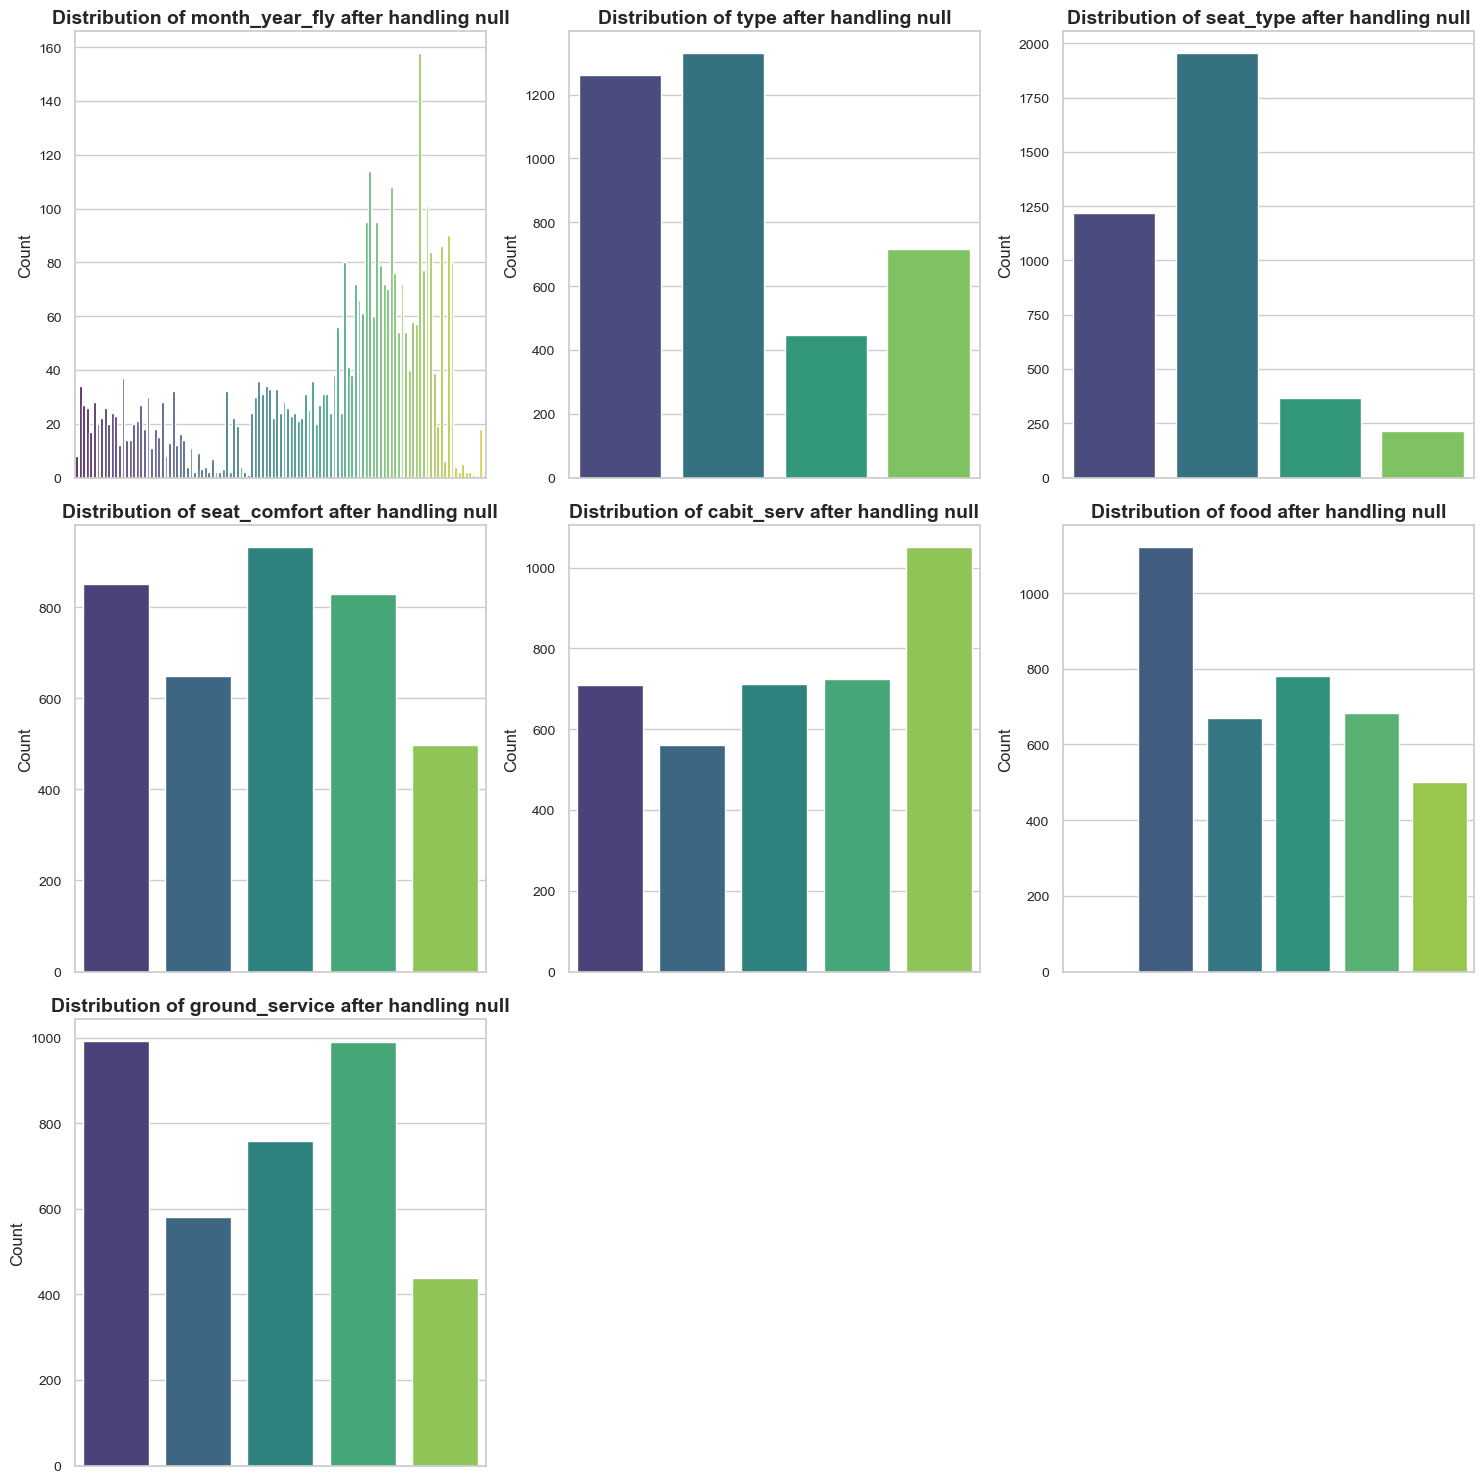

In [46]:
categorical_columns = ['month_year_fly', 'type', 'seat_type', 
                       'seat_comfort', 'cabit_serv', 'food', 'ground_service']
num_columns = 3
num_rows = (len(categorical_columns) - 1) // num_columns + 1

plt.figure(figsize=(15, num_rows * 5))
sns.set(style="whitegrid")

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.countplot(data=df, x=column, palette="viridis")
    plt.title(f'Distribution of {column} after handling null', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

plt.show()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3758 entries, 0 to 3757
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3758 non-null   int64  
 1   date_review     3758 non-null   object 
 2   verified        3758 non-null   int64  
 3   name            3758 non-null   object 
 4   month_year_fly  3758 non-null   object 
 5   country         3758 non-null   object 
 6   aircraft        3758 non-null   int64  
 7   type            3758 non-null   object 
 8   seat_type       3758 non-null   object 
 9   route           3758 non-null   object 
 10  seat_comfort    3758 non-null   float64
 11  cabit_serv      3758 non-null   float64
 12  food            3758 non-null   float64
 13  ground_service  3758 non-null   float64
 14  wifi            3758 non-null   int64  
 15  money_value     3758 non-null   int64  
 16  recommended     3758 non-null   int64  
 17  review          3758 non-null   o